In [37]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import glob,os
import cv2
import struct
import scipy.misc

In [6]:
path = '/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/'
filelist = glob.glob(path+'*Layers.seq')

In [8]:
filelist

['/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/5Layers.seq',
 '/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/4Layers.seq',
 '/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/2.5Layers.seq',
 '/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/9Layers.seq',
 '/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/3Layers.seq',
 '/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/7Layers.seq',
 '/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/6Layers.seq',
 '/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/8Layers.seq',
 '/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/2Layers.seq']

In [32]:
filename = filelist[0]
print(filename[:-4])

/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/5Layers


In [42]:
for i in range(len(filelist)):
    filename = filelist[i]
    print(filename)
    darkref = loadMRCfile(filename+'.dark.mrc')
    gainref = loadMRCfile(filename+'.gain.mrc')
    numframes, true_imagesize = loadHeader(filename,darkref)
    PACBED = saveTotalFile(filename, darkref, gainref, numframes, true_imagesize)
    PACBED[PACBED<0]=0
    # print(numframes,true_imagesize)
#     plt.imshow(np.sqrt(PACBED))
    np.save(filename[:-4]+'.npy',PACBED)
    scipy.misc.imsave(filename[:-4]+'_sqrt.tiff',np.sqrt(PACBED))

/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/5Layers.seq
Reading file /srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/5Layers.seq
Each frame is 2048 by 2048 px.
Total 100 frames collected.
Image acquired at 20.2020202020202 frames per second.


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if sys.path[0] == '':


/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/4Layers.seq
Reading file /srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/4Layers.seq
Each frame is 2048 by 2048 px.
Total 101 frames collected.
Image acquired at 20.2 frames per second.
/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/2.5Layers.seq
Reading file /srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/2.5Layers.seq
Each frame is 2048 by 2048 px.
Total 101 frames collected.
Image acquired at 20.2 frames per second.
/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/9Layers.seq
Reading file /srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/9Layers.seq
Each frame is 2048 by 2048 px.
Total 100 frames collected.
Image acquired at 20.2020202020202 frames per second.
/srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/3Layers.seq
Reading file /srv/home/chenyu/DEbackup/123119/uPSTEM_480CL_5_2APT/3Layers.seq
Each frame is 2048 by 2048 px.
Total 101 frames collected.
Image acquired at 20.2 frames per second.
/srv/hom

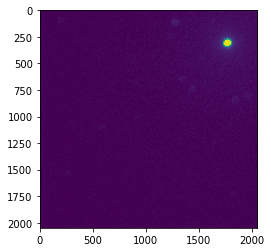

In [43]:
plt.imshow(np.sqrt(PACBED))

In [9]:
def loadMRCfile(filepath):
    with open(filepath, mode='rb') as file: # b is important -> binary
        file.seek(0)
        read_bytes = file.read(8)
        frame_width = struct.unpack('<i',read_bytes[0:4])
        frame_width = frame_width[0]
        frame_height = struct.unpack('<i',read_bytes[4:8])
        frame_height = frame_height[0]
        image = np.zeros((frame_height,frame_width))
        file.seek(256*4)
        dataset = file.read(frame_width*frame_height*4)
        for irow in range(frame_height):
            for icol in range(frame_width):
                pixel = struct.unpack('<f',dataset[(irow*frame_width+icol)*4:(irow*frame_width+icol+1)*4])[0]
                image[irow,icol] = pixel
        return image

In [10]:
def loadHeader(fileName,darkref):
    print('Reading file ' + fileName)
    with open(fileName, mode='rb') as file: # b is important -> binary
        file.seek(548)
        read_bytes = file.read(20)
        frame_width = struct.unpack('<L',read_bytes[0:4])
        frame_height = struct.unpack('<L',read_bytes[4:8])
        bit_depth = struct.unpack('<L',read_bytes[8:12])
        bit_depth_real = struct.unpack('<L',read_bytes[12:16])
        frame_bytesize = struct.unpack('<L',read_bytes[16:20])
        print('Each frame is ' + str(frame_width[0]) + ' by ' + str(frame_height[0]) + ' px.')

        file.seek(572)
        read_bytes = file.read(4)
        num_frames = struct.unpack('<i',read_bytes)
        print('Total ' + str(num_frames[0]) + ' frames collected.')

        file.seek(584)
        read_bytes = file.read(8)
        frame_rate = struct.unpack('<d',read_bytes)
        print('Image acquired at ' + str(frame_rate[0]) + ' frames per second.')

        file.seek(580)
        read_bytes = file.read(4)
        true_imagesize = struct.unpack('<L',read_bytes[0:4])

        if frame_width[0] != darkref.shape[0] or frame_height[0] != darkref.shape[1]:
            print('Norpix frame size (' + str(frame_height[0]) + ',' +str(frame_width[0]) +  ') disagree with reference size' + str(darkref.shape))
            
        return num_frames[0],true_imagesize[0]

In [41]:
def saveTotalFile(fileName, darkref, gainref, numframes, true_imagesize):
    PACBED = np.zeros((darkref.shape[0],darkref.shape[1]))
    with open(fileName, mode='rb') as file:
        for iframe in range(numframes):
            file.seek(8192 + iframe * true_imagesize)
            read_bytes = file.read(darkref.shape[0] * darkref.shape[1] * 2)
            frame_raw = np.reshape(np.frombuffer(read_bytes,dtype=np.uint16),darkref.shape)
            frame = frame_raw
            frame = (frame - darkref) * gainref
            frame[frame<30] = 0
            PACBED = PACBED + frame
#             PACBED = PACBED + (frame_raw - darkref)*gainref
        PACBED = PACBED / numframes
    return PACBED